In [ ]:
import librosa
import matplotlib.pyplot as plt
import librosa.display
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from scipy.io import wavfile
from scipy.stats import pearsonr
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from sklearn.preprocessing import MinMaxScaler

###Plant SpikerBox Data

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
def DataLoader(link, name_of_file):
  id = link.split("/")[-2]
  downloaded = drive.CreateFile({'id':id}) 
  downloaded.GetContentFile(name_of_file)
  samplerate, data = wavfile.read(name_of_file)
  return samplerate, data

In [ ]:
link = 'https://drive.google.com/file/d/19cjRyyg5JSNwxe-jenWbR2oqeRMlHEnc/view?usp=sharing'
name = 'spikerboxdata.wav'
sr, data = DataLoader(link, name)

In [ ]:
import datetime
print('Length ->', str(datetime.timedelta(seconds=round(len(data)/sr))), '(h,m,s) or',
      format(len(data),',d'), 'data points')
print('Sample rate ->', format(sr,',d'), 'samples per sec, or',
      sr/1000*1.00, 'kHz')

Length -> 4:23:06 (h,m,s) or 157,861,587 data points
Sample rate -> 10,000 samples per sec, or 10.0 kHz


In [ ]:
def DataLoaderLib(link, name_of_file):
  id = link.split("/")[-2]
  downloaded = drive.CreateFile({'id':id}) 
  downloaded.GetContentFile(name_of_file)
  x , sr = librosa.load(name_of_file, sr=10000)
  return x, sr

In [ ]:
xl, srl = DataLoaderLib(link, name)

In [ ]:
def ComputeMFCC(data, samplerate, no_of_seconds):
  x_short = data[:no_of_seconds]
  mfcc = librosa.feature.mfcc(x_short, sr=samplerate, hop_length=2000, n_fft=2500, n_mfcc=8)
  return mfcc

mfccs = ComputeMFCC(xl, srl, 5757000)

In [ ]:
def SPIPrePro(mfcc_data):
  mfcc_data_transpose = np.transpose(mfcc_data)
  mfcc_df = pd.DataFrame(mfcc_data_transpose)
  x = mfcc_df.values #returns a numpy array
  min_max_scaler = preprocessing.MinMaxScaler()
  x_scaled = min_max_scaler.fit_transform(x)
  mfcc_df = pd.DataFrame(x_scaled)
  mfcc_df.set_axis(['MFCC 1', 'MFCC 2', 'MFCC 3', 'MFCC 4', 'MFCC 5', 'MFCC 6', 'MFCC 7', 'MFCC 8'], axis='columns', inplace=True)
  series = pd.date_range(start='2022-03-09 17:54:03', end='2022-03-09 19:30:00', freq='2S')
  mfcc_df['timestamp'] = series
  mfcc_df.set_index("timestamp", inplace = True)
  return mfcc_df

mfcc_prepro = SPIPrePro(mfccs)

In [ ]:
def SPIInterpolation(mfcc_preprocessed_data):
  mfcc_resampled = mfcc_preprocessed_data.resample('60S').mean()
  mfcc_df_spikerbox = mfcc_resampled
  mfcc_df_spikerbox = mfcc_df_spikerbox.resample('S').mean()
  jazz_mfccs = mfcc_df_spikerbox.interpolate(method ='polynomial', order=3)
  return jazz_mfccs

spi_jazz_rehearsal = SPIInterpolation(mfcc_prepro)

In [ ]:
spi_jazz_rehearsal

,MFCC 1,MFCC 2,MFCC 3,MFCC 4,MFCC 5,MFCC 6,MFCC 7,MFCC 8
timestamp,,,,,,,,
2022-03-09 17:54:00,0.299310,0.642983,0.924750,0.868203,0.842421,0.738736,0.673170,0.688342
2022-03-09 17:54:01,0.299162,0.642209,0.923871,0.868588,0.842883,0.738640,0.673888,0.689141
2022-03-09 17:54:02,0.299017,0.641461,0.923026,0.868968,0.843336,0.738547,0.674580,0.689911
2022-03-09 17:54:03,0.298877,0.640738,0.922213,0.869345,0.843779,0.738459,0.675248,0.690652
2022-03-09 17:54:04,0.298742,0.640040,0.921433,0.869717,0.844213,0.738374,0.675893,0.691363
...,...,...,...,...,...,...,...,...
2022-03-09 19:28:56,0.286433,0.623153,0.930009,0.895751,0.857226,0.733746,0.676273,0.698048
2022-03-09 19:28:57,0.285112,0.621356,0.930430,0.896655,0.857264,0.733820,0.676488,0.698278
2022-03-09 19:28:58,0.283786,0.619545,0.930842,0.897549,0.857276,0.733872,0.676683,0.698485


In [ ]:
spi_jazz_rehearsal = spi_jazz_rehearsal.drop(['MFCC 1', 'MFCC 2', 'MFCC 3', 'MFCC 4', 'MFCC 5', 'MFCC 6', 'MFCC 8'], axis=1)

In [ ]:
spi_jazz_rehearsal.rename(columns = {'MFCC 7':'MFCC'}, inplace = True)

###Smartwatch Data

In [ ]:
def DataLoader(link, name_of_file):
  id = link.split("/")[-2]
  downloaded = drive.CreateFile({'id':id}) 
  downloaded.GetContentFile(name_of_file)
  dataframe = pd.read_csv(name_of_file)
  return dataframe

link = 'https://drive.google.com/file/d/1A46FlopzRBsaLeq0-NawM5xRpcpxQ2I2/view?usp=sharing'
name = 'user_sensor_data.csv'
df_happimeter = DataLoader(link, name)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
rehearsal_start_stamp = '3/9/22 17:49'
rehearsal_end_stamp = '3/9/22 19:33'

In [ ]:
drop_columns = ['id', 'sensor_data_v2_id', 'watch_battery_percentage','watch_app_version', 'phone_app_version', 'number_of_measures', 'stdDev', 'magnitude','quantile1', 'quantile2', 'quantile3', 'min', 'max']

In [ ]:
def segregate(df, start_stamp, end_stamp):
  return df[(df['timestamp'] >= start_stamp) & (df['timestamp'] <= end_stamp)] 

df_rehearsal = segregate(df_happimeter, rehearsal_start_stamp, rehearsal_end_stamp)

In [ ]:
def drop(df, columns):
  return df.drop(columns, axis = 1)

df_rehearsal = drop(df_rehearsal, drop_columns)

In [ ]:
def drop_rows(df):
  index_names = df[ (df['type'] == 'LocationLat') | (df['type'] == 'LocationLon') | (df['type'] == 'LocationAlt') | (df['type'] == 'Step') | (df['type'] == 'AccelerometerMagX') | (df['type'] == 'AccelerometerMagY') | (df['type'] == 'AccelerometerMagZ') | (df['type'] == 'VMC') | (df['type'] == 'ActivityStill') | (df['type'] == 'ActivityInCar') | (df['type'] == 'ActivityUnspecific') | (df['type'] == 'ActivityOnFoot') | (df['type'] == 'ActivityWalking') | (df['type'] == 'ActivityRunning') | (df['type'] == 'ActivityOnBicycle') | (df['type'] == 'HeartrateClean') | (df['type'] == 'Microphone') ].index
  df.drop(index_names, inplace = True)
  return df

df_rehearsal = drop_rows(df_rehearsal)

In [ ]:
def timeindex(df):
  df['timestamp'] = pd.to_datetime(df['timestamp'])
  df = df.set_index('timestamp')
  return df

df_rehearsal = timeindex(df_rehearsal)

In [ ]:
def UserAugment(userid, dfproc1):
  df_user = dfproc1.loc[dfproc1['user_id'] == userid]
  df_accx = df_user.loc[df_user['type'] == "AccelerometerX"]
  df_accy = df_user.loc[df_user['type'] == "AccelerometerY"]
  df_accz = df_user.loc[df_user['type'] == "AccelerometerZ"]
  df_hr = df_user.loc[df_user['type'] == "Heartrate"]
  df_user_new = df_accx.drop(['type'], axis=1)
  df_user_new = df_user_new.rename(columns = {'average':'AccelerometerX'})
  df_user_new = df_user_new.resample('S').mean()
  df_user_new = df_user_new.interpolate(method ='polynomial', order=3)
  df_accy = df_accy.resample('S').mean()
  df_accy = df_accy.interpolate(method ='polynomial', order=3)
  df_accz = df_accz.resample('S').mean()
  df_accz = df_accz.interpolate(method ='polynomial', order=3)
  df_hr = df_hr.resample('S').mean()
  df_hr = df_hr.interpolate(method ='polynomial', order=3)
  accelerometery = df_accy['average']
  accelerometerz = df_accz['average']
  heartrate = df_hr['average']
  df_user_new['AccelerometerY'] = accelerometery
  df_user_new['AccelerometerZ'] = accelerometerz
  df_user_new['HeartRate'] = heartrate
  return df_user_new

In [ ]:
def AugmentUser(userid, dfproc2):
  df_final = dfproc2.assign(Movement=lambda x: np.sqrt(x['AccelerometerX'] ** 2 + x['AccelerometerY'] ** 2 + x['AccelerometerZ'] ** 2))
  df_final = df_final.drop(['AccelerometerX', 'AccelerometerY', 'AccelerometerZ'], axis=1)
  df_final['user_id'] = userid
  return df_final

In [ ]:
def FinalUser(userid, df):
  dfproc1 = UserAugment(userid, df)
  dfproc2 = AugmentUser(userid, dfproc1)
  dfproc2 = dfproc2[(dfproc2.index >= '2022-03-09 17:54:00') & (dfproc2.index <= '2022-03-09 19:28:30')]
  dfproc2 = dfproc2.drop(['user_id'], axis=1)
  dfproc2['HeartRate'] = MinMaxScaler().fit_transform(np.array(dfproc2['HeartRate']).reshape(-1,1))
  dfproc2['Movement'] = MinMaxScaler().fit_transform(np.array(dfproc2['Movement']).reshape(-1,1))
  dfproc2 = dfproc2.rename(columns = {'HeartRate':'HeartRate '+ str(userid), 'Movement':'Movement '+ str(userid)})
  downsample = dfproc2.resample('60S').mean()
  downsample_duplicate = downsample
  upsample = downsample_duplicate.resample('S').mean()
  df_userid = upsample.interpolate(method ='polynomial', order=3)
  return df_userid

In [ ]:
df_420 = FinalUser(420, df_rehearsal)
df_2197 = FinalUser(2197, df_rehearsal)
df_2193 = FinalUser(2193, df_rehearsal)
df_2196 = FinalUser(2196, df_rehearsal)
df_787 = FinalUser(787, df_rehearsal)
df_2190 = FinalUser(2190, df_rehearsal)
df_2194 = FinalUser(2194, df_rehearsal)
df_894 = FinalUser(894, df_rehearsal)
df_798 = FinalUser(798, df_rehearsal)
df_974 = FinalUser(974, df_rehearsal)
df_789 = FinalUser(789, df_rehearsal)
df_1144 = FinalUser(1144, df_rehearsal)
df_797 = FinalUser(797, df_rehearsal)
df_796 = FinalUser(796, df_rehearsal)
df_795 = FinalUser(795, df_rehearsal)
df_2189 = FinalUser(2189, df_rehearsal)
df_788 = FinalUser(788, df_rehearsal)
df_972 = FinalUser(972, df_rehearsal)
df_799 = FinalUser(799, df_rehearsal)
df_2191 = FinalUser(2191, df_rehearsal)
df_2192 = FinalUser(2192, df_rehearsal)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:462: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [ ]:
audience = [spi_jazz_rehearsal, df_2197, df_2193]
drums = [spi_jazz_rehearsal, df_2196, df_787, df_2190]
vocals = [spi_jazz_rehearsal, df_2194, df_894, df_798]
saxophone = [spi_jazz_rehearsal, df_974, df_789, df_1144, df_797, df_795]
sax_star = [spi_jazz_rehearsal, df_796, df_2189]

In [ ]:
import functools as ft
df_audience = ft.reduce(lambda left, right: pd.merge(left, right, on='timestamp'), audience)
df_drums = ft.reduce(lambda left, right: pd.merge(left, right, on='timestamp'), drums)
df_vocals = ft.reduce(lambda left, right: pd.merge(left, right, on='timestamp'), vocals)
df_saxophone = ft.reduce(lambda left, right: pd.merge(left, right, on='timestamp'), saxophone)
df_sax_star = ft.reduce(lambda left, right: pd.merge(left, right, on='timestamp'), sax_star)

In [ ]:
df_drums['MOV Avg Drums'] = df_drums[['Movement 2196', 'Movement 787', 'Movement 2190']].mean(axis=1)
df_drums = df_drums.drop(['HeartRate 2196', 'HeartRate 787', 'HeartRate 2190', 'Movement 2196', 'Movement 787', 'Movement 2190'], axis=1)
df_vocals['MOV Avg Vocals'] = df_vocals[['Movement 2194', 'Movement 894', 'Movement 798']].mean(axis=1)
df_vocals = df_vocals.drop(['HeartRate 2194', 'HeartRate 894', 'HeartRate 798', 'Movement 2194', 'Movement 894', 'Movement 798'], axis=1)
df_saxophone['MOV Avg Sax'] = df_saxophone[['Movement 974', 'Movement 789', 'Movement 1144', 'Movement 797', 'Movement 795']].mean(axis=1)
df_saxophone = df_saxophone.drop(['HeartRate 974', 'HeartRate 789', 'HeartRate 1144', 'HeartRate 797', 'HeartRate 795','Movement 974', 'Movement 789', 'Movement 1144', 'Movement 797', 'Movement 795'], axis=1)
df_sax_star['MOV Sax Stars'] = df_sax_star[['Movement 796', 'Movement 2189']].mean(axis=1)
df_sax_star = df_sax_star.drop(['HeartRate 796', 'HeartRate 2189', 'Movement 796', 'Movement 2189'], axis=1)
df_audience['MOV Avg Audi'] = df_audience[['Movement 2197', 'Movement 2193']].mean(axis=1)
df_audience = df_audience.drop(['HeartRate 2197', 'HeartRate 2193', 'Movement 2197', 'Movement 2193'], axis=1)

###Correlations of Plant Data and Smartwatch Data 

Drum Players

In [ ]:
df_drums.corr()

,MFCC,MOV Avg Drums
MFCC,1.000000,-0.417648
MOV Avg Drums,-0.417648,1.000000


In [ ]:
corr, sig = pearsonr(df_drums['MFCC'], df_drums['MOV Avg Drums'])
print('Pearsons correlation: %.3f' %corr)
print('Significance Value: %.3f' %sig)

Pearsons correlation: -0.418
Significance Value: 0.000


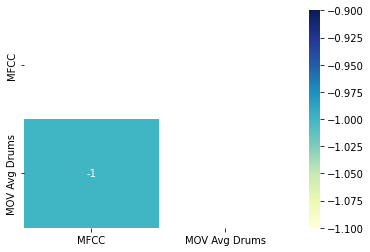

In [ ]:
mask = np.triu(np.ones_like(df_drums.corr().corr()))
dataplot = sns.heatmap(df_drums.corr().corr(), cmap="YlGnBu", annot=True, mask=mask)
plt.show()

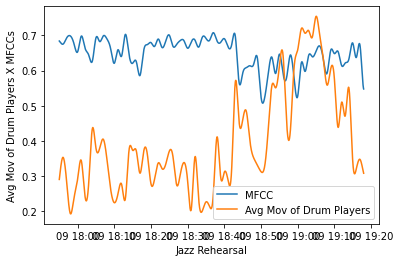

In [ ]:
sns.lineplot(x="timestamp", y="MFCC", data=df_drums, label='MFCC')
sns.lineplot(x="timestamp", y="MOV Avg Drums", data=df_drums, label='Avg Mov of Drum Players')

plt.ylabel("Avg Mov of Drum Players X MFCCs")
plt.xlabel("Jazz Rehearsal")
plt.show()

Vocal Singers

In [ ]:
df_vocals.corr()

,MFCC,MOV Avg Vocals
MFCC,1.000000,-0.653765
MOV Avg Vocals,-0.653765,1.000000


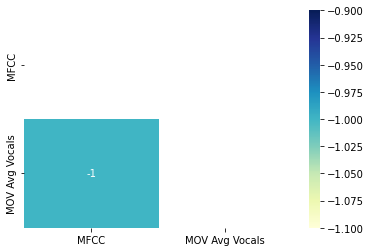

In [ ]:
mask = np.triu(np.ones_like(df_vocals.corr().corr()))
dataplot = sns.heatmap(df_vocals.corr().corr(), cmap="YlGnBu", annot=True, mask=mask)
plt.show()

In [ ]:
corr, sig = pearsonr(df_vocals['MFCC'], df_vocals['MOV Avg Vocals'])
print('Pearsons correlation: %.3f' %corr)
print('Significance Value: %.3f' %sig)

Pearsons correlation: -0.654
Significance Value: 0.000


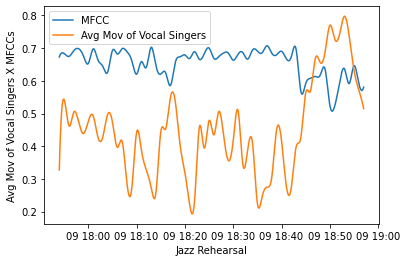

In [ ]:
sns.lineplot(x="timestamp", y="MFCC", data=df_vocals, label='MFCC')
sns.lineplot(x="timestamp", y="MOV Avg Vocals", data=df_vocals, label='Avg Mov of Vocal Singers')

plt.ylabel("Avg Mov of Vocal Singers X MFCCs")
plt.xlabel("Jazz Rehearsal")
plt.show()

Saxophone Players

In [ ]:
df_saxophone.corr()

,MFCC,MOV Avg Sax
MFCC,1.000000,0.212273
MOV Avg Sax,0.212273,1.000000


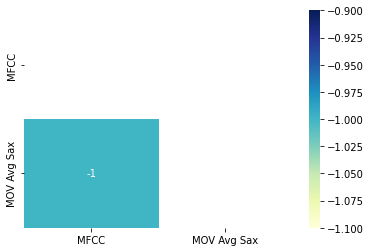

In [ ]:
mask = np.triu(np.ones_like(df_saxophone.corr().corr()))
dataplot = sns.heatmap(df_saxophone.corr().corr(), cmap="YlGnBu", annot=True, mask=mask)
plt.show()

In [ ]:
corr, sig = pearsonr(df_saxophone['MFCC'], df_saxophone['MOV Avg Sax'])
print('Pearsons correlation: %.3f' %corr)
print('Significance Value: %.3f' %sig)

Pearsons correlation: 0.212
Significance Value: 0.000


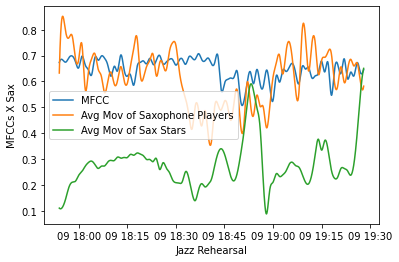

In [ ]:
sns.lineplot(x="timestamp", y="MFCC", data=df_saxophone, label='MFCC')
sns.lineplot(x="timestamp", y="MOV Avg Sax", data=df_saxophone, label='Avg Mov of Saxophone Players')
sns.lineplot(x="timestamp", y="MOV Sax Stars", data=df_sax_star, label='Avg Mov of Sax Stars')


plt.ylabel("MFCCs X Sax")
plt.xlabel("Jazz Rehearsal")
plt.show()

Sax Stars

In [ ]:
df_sax_star.corr()

,MFCC,MOV Sax Stars
MFCC,1.000000,-0.285797
MOV Sax Stars,-0.285797,1.000000


In [ ]:
corr, sig = pearsonr(df_sax_star['MFCC'], df_sax_star['MOV Sax Stars'])
print('Pearsons correlation: %.3f' %corr)
print('Significance Value: %.3f' %sig)

Pearsons correlation: -0.286
Significance Value: 0.000


Audience 

In [ ]:
df_audience.corr()

,MFCC,MOV Avg Audi
MFCC,1.000000,-0.000999
MOV Avg Audi,-0.000999,1.000000


In [ ]:
corr, sig = pearsonr(df_audience['MFCC'], df_audience['MOV Avg Audi'])
print('Pearsons correlation: %.3f' %corr)
print('Significance Value: %.3f' %sig)

Pearsons correlation: -0.001
Significance Value: 0.940
